## Importing the LonelyBoy Library (github.com/insert-generic-name-here/lonelyboy)

In [26]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'Code'))
# sys.path

from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
from lonelyboy.geospatial import group_patterns as gsgp
from lonelyboy.geospatial import moving_patterns as gsmp

## Importing all other Essential Libraries
#### (DO NOT FORGET TO EXECUTE THE FUNCTIONS IN THE BOTTOM CELLS)

In [27]:
import psycopg2
import numpy as np
import configparser
import pandas as pd
import geopandas as gpd
import contextily as ctx
from random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point, LineString, shape
from haversine import haversine
from datetime import datetime, timedelta

In [28]:
from multiprocessing import cpu_count, Pool
from functools import partial
import datetime

## Import Libraries for Visualizations

In [119]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# import PyQt5
import matplotlib.pyplot as plt
from matplotlib import style;  style.use('ggplot')
# get_ipython().magic('matplotlib qt')

##  Importing the Server Credentials & Connectiing to Server and Fetch 48hrs of Trajectory Data

In [16]:
# properties = configparser.ConfigParser()
# properties.read(os.path.join('.','sql_server.ini'))
# properties = properties['SERVER']

# host    = properties['host']
# db_name = properties['db_name']
# uname   = properties['uname']
# pw      = properties['pw']
# port    = properties['port']

host    = '195.251.230.8'
db_name = 'doi105281zenodo1167595'
uname   = 'students'
pw      = 'infol@bdbl@bs2017'
port    = '46132'


traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE ts>1456802710 AND ts<1456975510  '
ports_sql = 'SELECT * FROM ports.ports_of_brittany'

con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)

traj = gpd.GeoDataFrame.from_postgis(traj_sql, con, geom_col='geom' )

ports = gpd.GeoDataFrame.from_postgis(ports_sql, con, geom_col='geom' )
ports.geom = ports.geom.apply(lambda x: x[0])

con.close()

In [7]:
ports.head(2)

,gid,gml_id,por_id,libelle_po,insee_comm,por_x,por_y,geom
0,1,port.1,1,Le Vivier-sur-Mer,35361,297025.0,2408370.0,POINT (-1.771798868659233 48.60274269672541)
1,2,port.10,10,Saint-Samson sur Rance,22327,279335.0,2396060.0,POINT (-2.001990119062326 48.48369993456267)


## Let's get dangerous (got the reference?)

* ### Step 1: Denoising

In [17]:
#### DROP TIMESTAMP DUPLICATES PER MMSI
sample_trajectories = traj
sample_trajectories = sample_trajectories.drop_duplicates(subset=['mmsi', 'ts']).sort_values('ts').reset_index(drop=True)
sample_trajectories.head()

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
0,12293631,227705102,15.0,-127.0,0.0,261.8,511,-4.496568,48.382435,1456802711,POINT (-4.496568 48.382435)
1,12293630,227941000,7.0,0.0,0.0,285.0,8,-4.327213,48.100086,1456802711,POINT (-4.3272133 48.100086)
2,12293633,227008170,0.0,0.0,0.0,135.0,144,-4.486115,48.381565,1456802713,POINT (-4.486115 48.381565)
3,12293632,227016100,0.0,0.0,0.0,264.3,174,-4.481568,48.381393,1456802713,POINT (-4.4815683 48.381393)
4,17515087,256494000,5.0,0.0,0.0,344.0,217,-4.451149,48.383625,1456802713,POINT (-4.4511485 48.383625)


In [11]:
### DROP OUTLIERS IN SAMPLE_TRAJECTORIES BASED ON TIMESTAMP ---- IDK IF I'LL APPLY THIS OR NOT (SO FAR: NOT APPLIED)
# indices = [item for sublist in [x for x in gdf.groupby(['mmsi'])['ts'].apply(lambda x: get_outliers(x)[0]) if x != []] for item in sublist]
# sample_trajectories.drop(indices, inplace=True)

In [18]:
### CALCULATE VELOCITIES BASED ON THE POINTS
sample_trajectories['velocity'] = np.nan
sample_trajectories = sample_trajectories.groupby(['mmsi'], as_index=False).apply(gspp.calculate_velocity, smoothing=False, window=15, center=False).reset_index(drop=True)

### DENOISE SAMPLE_TRAJECTORIES BASED ON A VELOCITY THRESHOLD (POTENTIAL-AREA-OF-ACTIVITY)
sample_trajectories = gspp.PotentialAreaOfActivity(sample_trajectories, velocity_threshold = 102.2)
sample_trajectories

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,velocity
0,17552952,212228000,0.0,-126.0,5.5,37.0,17,-5.628232,48.721220,1456930088,POINT (-5.6282315 48.72122),5.500000
1,17516776,212518000,0.0,0.0,10.6,155.2,155,-5.398723,48.202198,1456810995,POINT (-5.398723 48.202198),11.876869
2,17517323,212518000,0.0,127.0,10.9,153.6,158,-5.283112,48.040985,1456814595,POINT (-5.2831116 48.040985),0.000000
3,12655544,215477000,0.0,0.0,11.3,119.3,124,-5.098250,48.289906,1456865914,POINT (-5.09825 48.289906),15.360757
4,12655606,215477000,0.0,-126.0,11.0,125.0,122,-5.095583,48.288727,1456865955,POINT (-5.0955834 48.288727),15.424754
5,12655719,215477000,0.0,0.0,11.6,123.1,125,-5.090328,48.286488,1456866035,POINT (-5.090328 48.286488),15.458755
6,12655840,215477000,0.0,0.0,11.4,120.0,126,-5.084340,48.283928,1456866126,POINT (-5.08434 48.283928),15.371953
7,12655869,215477000,0.0,-126.0,11.6,126.2,124,-5.083053,48.283320,1456866146,POINT (-5.083053 48.28332),15.701499
8,17533416,215477000,0.0,-126.0,11.2,123.2,112,-5.077209,48.280720,1456866234,POINT (-5.0772085 48.28072),15.609783
9,17533420,215477000,0.0,-126.0,11.0,115.3,111,-5.076662,48.280533,1456866242,POINT (-5.0766616 48.280533),15.824686


In [19]:
# ### RESAMPLE TRAJECTORIES
sample_trajectories_resampled = sample_trajectories.groupby(['mmsi'], as_index=False).apply(gspp.resample_geospatial, rule = '60S', method='linear', crs = {'init': 'epsg:4326'}, drop_lon_lat = False).reset_index(drop=True) 
sample_trajectories_resampled.sort_values(['datetime'], ascending=True, inplace=True)

## Plot the Preprocessed Trajectories (just to be sure)

In [ ]:
ax = sample_trajectories_resampled.to_crs(epsg=3857).plot(figsize=(10, 10))
ctx.add_basemap(ax, zoom=11)
plt.show()

## Flock/Convoy Mining Algorithm Testing will take place in 2h of data

In [91]:
lol = pd.read_csv('4h_timeFrame.csv')

In [92]:
lol

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,velocity,datetime
0,1.257696e+07,227006750.0,0.0,0.000000,0.000000,268.500000,268.000000,-4.484462,48.381145,1.456803e+09,POINT (-4.484462 48.381145),0.307191,2016-03-01 03:26:00
1,1.751510e+07,227300000.0,7.0,-126.000000,1.500000,21.200000,322.000000,-4.631639,48.111740,1.456803e+09,POINT (-4.6316385 48.11174),1.395733,2016-03-01 03:26:00
2,1.754235e+07,256494000.0,5.0,0.000000,0.000000,344.000000,217.000000,-4.451143,48.383625,1.456803e+09,POINT (-4.451143 48.383625),0.019396,2016-03-01 03:26:00
3,1.257696e+07,227705102.0,15.0,-127.000000,0.000000,282.600000,511.000000,-4.496595,48.382440,1.456803e+09,POINT (-4.496595 48.38244),0.056881,2016-03-01 03:26:00
4,1.754237e+07,220417000.0,1.0,0.000000,0.066667,170.400000,242.333333,-4.484998,48.352693,1.456803e+09,POINT (-4.484997766666667 48.35269333333333),0.072627,2016-03-01 03:26:00
5,1.257697e+07,227574020.0,15.0,-127.000000,0.000000,237.500000,511.000000,-4.496685,48.382427,1.456803e+09,POINT (-4.496685 48.382427),0.186221,2016-03-01 03:26:00
6,1.257696e+07,228186700.0,15.0,-127.000000,102.300000,360.000000,511.000000,-4.512577,48.370872,1.456803e+09,POINT (-4.5125766 48.370872),0.059529,2016-03-01 03:26:00
7,1.257696e+07,227008170.0,0.0,0.000000,0.000000,135.000000,143.000000,-4.486115,48.381550,1.456803e+09,POINT (-4.486115 48.38155),0.000000,2016-03-01 03:26:00
8,1.257696e+07,228394000.0,7.0,-127.000000,0.600000,77.800000,511.000000,-4.654207,48.123140,1.456803e+09,POINT (-4.6542068 48.12314),1.905563,2016-03-01 03:26:00
9,1.754236e+07,227222000.0,5.0,0.000000,0.000000,167.400000,167.000000,-4.477003,48.382120,1.456803e+09,POINT (-4.477003 48.38212),0.000000,2016-03-01 03:26:00


In [44]:
timeWindow = sample_trajectories_resampled.datetime.unique()[250]
timeWindow = [timeWindow + np.timedelta64(60*i, 's') for i in range(1, 242)] #4H
# timeWindow = [timeWindow + np.timedelta64(60*i, 's') for i in range(1, 121)] #2H
# timeWindow = [timeWindow + np.timedelta64(60*i, 's') for i in range(1, 61)] #1H
# timeWindow = [timeWindow + np.timedelta64(60*i, 's') for i in range(1, 31)] #30MIN
sample_timeFrame = sample_trajectories_resampled.loc[sample_trajectories_resampled.datetime.isin(timeWindow)].sort_values('datetime').reset_index(drop=True)
# sample_timeFrame = sample_trajectories_resampled
sample_timeFrame.head()

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,velocity,datetime
0,1.884809e+07,227408710.0,0.0,0.0,0.000000,258.100000,511.000000,-4.490398,48.379187,1.456818e+09,POINT (-4.4903984 48.3791865),0.013741,2016-03-01 07:36:00
1,1.758572e+07,228853000.0,7.0,-127.0,6.169685,200.775984,511.000000,-3.891684,47.732670,1.456818e+09,POINT (-3.891684385826772 47.73266998031496),0.153449,2016-03-01 07:36:00
2,1.884808e+07,227686540.0,0.0,0.0,6.400000,199.300000,511.000000,-4.464395,48.327780,1.456818e+09,POINT (-4.464395 48.32778),6.911790,2016-03-01 07:36:00
3,1.751793e+07,226216000.0,7.0,0.0,0.000000,196.639167,302.466667,-4.175265,47.835712,1.456818e+09,POINT (-4.175265398333333 47.83571188333333),0.001396,2016-03-01 07:36:00
4,1.751790e+07,227270000.0,5.0,-127.0,0.000000,0.000000,511.000000,-4.478274,48.383153,1.456818e+09,POINT (-4.478274466666667 48.38315333333333),0.003177,2016-03-01 07:36:00


In [45]:
sample_timeFrame.to_csv('4h_timeFrame_not_at_3_fing_am.csv', index=False)

## Search for Flocks/Convoys
* #### 1. The Clustering will take place in time slices 
* #### 2. Possible Features: (X_coord, Y_coord, course)

In [133]:
flocks_cluster = gsmp.flocks(sample_timeFrame, 5)
flocks_cluster_filtered = flocks_cluster.drop(columns=['index', 'id', 'status', 'turn', 'speed', 'course', 'heading', 'lon', 'lat', 'ts', 'velocity'], axis=1) 

In [134]:
flocks_cluster_filtered = flocks_cluster_filtered.reset_index(drop=True)

In [135]:
flocks_cluster_filtered.crs = {'init': 'epsg:4326'}

In [136]:
tflst = []
for _, df in flocks_cluster_filtered.groupby('datetime'):
    
    tflst.append(df)

In [137]:
ts = tflst[0]

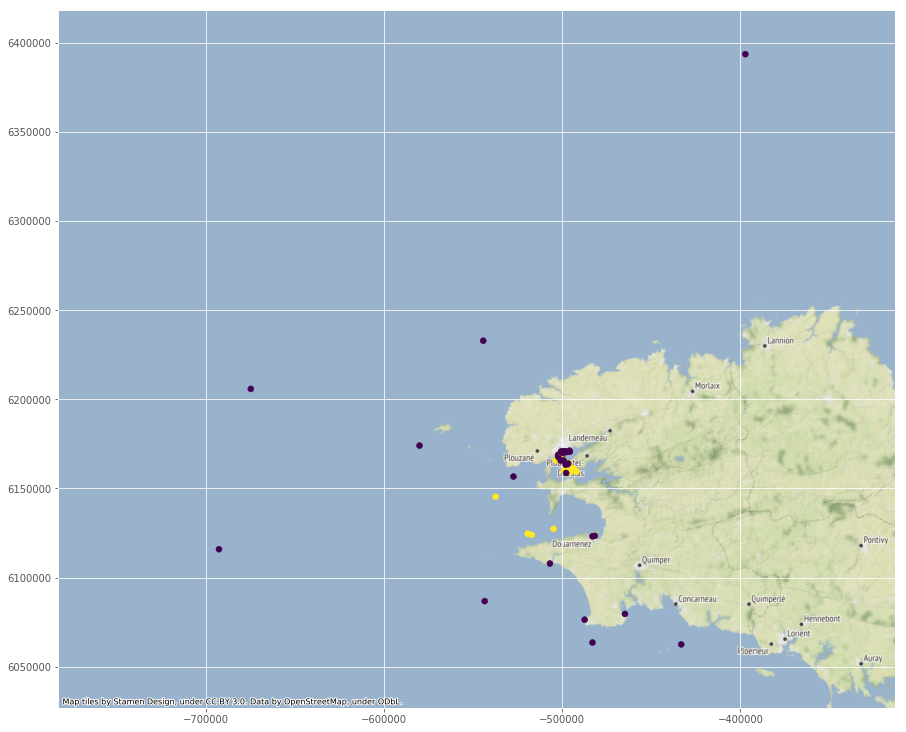

In [138]:
ax = ts.to_crs(epsg=3857).plot(figsize=(15,15), c=ts.flock_label)
ctx.add_basemap(ax)

In [139]:
ts

,mmsi,geom,datetime,flock_label
0,227686540.0,POINT (-4.464395 48.32778),2016-03-01 07:36:00,0
1,227632830.0,POINT (-4.4594316 48.32466),2016-03-01 07:36:00,0
2,227941000.0,POINT (-4.327215 48.100086),2016-03-01 07:36:00,0
3,256494000.0,POINT (-4.4931483 48.356632),2016-03-01 07:36:00,0
4,227588970.0,POINT (-4.451975 48.3136),2016-03-01 07:36:00,0
5,234056000.0,POINT (-4.7373915 48.298428),2016-03-01 07:36:00,-1
6,227142200.0,POINT (-4.3273916 48.09936),2016-03-01 07:36:00,0
7,227298110.0,POINT (-4.489414 48.379012),2016-03-01 07:36:00,0
8,228762000.0,POINT (-4.5236135 48.35285),2016-03-01 07:36:00,0
9,227008170.0,POINT (-4.486165 48.3815),2016-03-01 07:36:00,0


In [140]:
ts.flock_label.value_counts()

-1    39
 0    32
Name: flock_label, dtype: int64

In [117]:
plt.ioff()

In [137]:
# flocks_cluster.datetime.unique()
tmpA = flocks_cluster_filtered.loc[(flocks_cluster_filtered.datetime == np.datetime64('2016-03-01T03:43:00.000000000')) & (flocks_cluster_filtered.flock_label != -1)]
tmpA
# tmp.plot(column='flock_label', figsize=(20,20), cmap='Set1')

tmpB = flocks_cluster_filtered.loc[(flocks_cluster_filtered.datetime == np.datetime64('2016-03-01T03:44:00.000000000')) & (flocks_cluster_filtered.flock_label != -1)]
tmpB

,mmsi,geom,datetime,flock_label
509,227016100.0,POINT (-4.48167 48.381294),2016-03-01 03:43:00,0
510,227298110.0,POINT (-4.4893885 48.379032),2016-03-01 03:43:00,0
513,228186700.0,POINT (-4.5125866 48.37086),2016-03-01 03:43:00,0
514,228394000.0,POINT (-4.646527 48.12488),2016-03-01 03:43:00,1
515,244630187.0,POINT (-4.4884534 48.37732),2016-03-01 03:43:00,0
516,227006750.0,POINT (-4.484443 48.381153),2016-03-01 03:43:00,0
517,227300000.0,POINT (-4.6235833 48.112854),2016-03-01 03:43:00,1
522,227088590.0,POINT (-4.487519 48.37800066666667),2016-03-01 03:43:00,0
523,227002330.0,POINT (-4.485903333333333 48.38144933333333),2016-03-01 03:43:00,0


In [163]:
flocks_cluster_filtered = flocks_cluster_filtered.loc[flocks_cluster_filtered.flock_label != -1]
flocks_cluster_filtered

,mmsi,geom,datetime,flock_label
5,228186700.0,POINT (-4.5125766 48.370872),2016-03-01 03:26:00,0
6,227003050.0,POINT (-4.4857435 48.381115),2016-03-01 03:26:00,0
21,227574020.0,POINT (-4.4966965 48.38245),2016-03-01 03:27:00,0
22,227008170.0,POINT (-4.486165 48.3815),2016-03-01 03:27:00,0
23,227016100.0,POINT (-4.481573 48.381393),2016-03-01 03:27:00,0
24,228186700.0,POINT (-4.512582 48.370865),2016-03-01 03:27:00,0
26,227003050.0,POINT (-4.485745 48.381123),2016-03-01 03:27:00,0
38,636015106.0,POINT (-4.474264166666667 48.33944333333334),2016-03-01 03:27:00,0
39,227270000.0,POINT (-4.4782734 48.383152),2016-03-01 03:27:00,0
46,227016100.0,POINT (-4.481583 48.3814),2016-03-01 03:28:00,0


In [167]:
history = flocks_cluster_filtered.loc[flocks_cluster_filtered.datetime == flocks_cluster_filtered.datetime.min()]

for doi, timeFrameClusters in flocks_cluster_filtered.groupby(['datetime'], as_index=False):
    tmp = history.groupby(['flock_label'], as_index=False).apply(pd.merge, timeFrameClusters, on=['mmsi'], how='inner', suffixes=('DROPME', ''))
    history = tmp[[c for c in tmp.columns if 'DROPME' not in c]]

          mmsi                          geom            datetime  flock_label
5  228186700.0  POINT (-4.5125766 48.370872) 2016-03-01 03:26:00            0
6  227003050.0  POINT (-4.4857435 48.381115) 2016-03-01 03:26:00            0


In [ ]:
history = sample_timeFrame2.loc[sample_timeFrame2.datetime == sample_timeFrame2.datetime.min()]
hist_lst = []
lst = []

for doi, timeFrameClusters in sample_timeFrame2.groupby(['datetime'], as_index=False):
    for label, cluster in timeFrameClusters.groupby(['labels'], as_index=False):
        tmp = pd.merge(history, cluster, how='inner', on=['mmsi'])
        if not len(tmp) == 0:
            lst.append(tmp)
        else:
            lst.append(cluster)
    
    history = pd.concat(lst)
    hist_lst.append(lst)
    lst = []

* #### Set up a Color Map (for the Plots)

In [8]:
LABEL_COLOR_MAP = {-1 : 'black', 0 : 'white', 1 : 'r', 2 : 'g',\
                   3 : 'b', 4 : 'm', 5 : 'y', 6 : 'maroon', 7 : 'pink',\
                   8 : 'sienna', 9 : 'darkslategray', 10 : 'purple', 
                   11 : 'darkgoldenrod', 12: 'chocolate'}

In [9]:
def join_geospatial(df_left, df_right, condition, mode):
    if (len(df_left) == 0):
        return df_right
    
    df_result = pd.DataFrame([], columns=[mode, 'start_time', 'end_time'])
    indices = []
    left_indices = []
    
    for idx_left, cluster_left in enumerate(df_left[mode]):
        for idx_right, cluster_right in enumerate(df_right[mode]):
            if condition(cluster_left, cluster_right):                
                res = pd.DataFrame([{mode:cluster_left.intersection(cluster_right), 'start_time':df_left.iloc[idx_left].start_time, 'end_time':df_right.iloc[idx_right].start_time}], columns=[mode, 'start_time', 'end_time'])  
                df_result = df_result.append(res, ignore_index=True)
                indices.append(idx_right)
                left_indices.append(idx_left)
                break
        
    left_indices = np.delete(df_left.index.values, left_indices)
    indices = np.delete(df_right.index.values, indices)
    df_result = df_result.append(df_left.iloc[left_indices], ignore_index=True)
    df_result = df_result.append(df_right.iloc[indices], ignore_index=True)
    return df_result

In [10]:
def group_patterns_mining(gdf, normalizing_algorithm, clustering_algorithm, verification_process, mode, time_threshold=5, min_samples=2, resampling_rate=60): 
    '''
    Search for Flocks/Convoys, given a GeoDataFrame.
    '''    
    cmc_verification_partial = partial(verification_process, min_samples=min_samples)
    gp_history = pd.DataFrame([], columns=[mode, 'start_time', 'end_time'])
    
    for doi, timeFrame in gdf.groupby(['datetime'], as_index=False):   
        print (f'Datetime of Interest: {doi}\r', end='')    
        X = normalizing_algorithm(timeFrame[['lon', 'lat']].values)
        cluster_n = clustering_algorithm(X)
        # Create the DataFrame (Structure: <INDEX_OF_CLUSTER>, <LIST_OF_TIMEFRAME_INDICES>)
        if not (len(cluster_n) == 1 and cluster_n[0] == -1):
            tmp = pd.DataFrame(np.array([timeFrame['mmsi'], cluster_n]).T, columns=[mode, 'cluster_idx'])
            tmp = tmp.loc[tmp.cluster_idx != -1].groupby('cluster_idx')[mode].apply(list).apply(set)
            tmp = pd.DataFrame({mode:tmp, 'start_time':np.array([doi]*len(tmp))}, columns=[mode, 'start_time', 'end_time'])
            # Append to Convoy History
            gp_history = join_geospatial(gp_history, tmp, cmc_verification_partial, mode=mode)
    
    gp_history.dropna(inplace=True)
    gp_history.sort_values('start_time', inplace=True)
    return gp_history.loc[(gp_history.end_time.apply(lambda ts: ts.timestamp()) - gp_history.start_time.apply(lambda ts: ts.timestamp()) >= (time_threshold*resampling_rate))  
                          & (gp_history[mode].apply(len) >= min_samples)].reset_index(drop=True)

In [17]:
normalizing_algorithm = partial(gsgp.MinMax_Scaler, feature_range=(0, 1), copy=True)
clustering_algorithm = partial(gsgp.DBSCAN_Clustering, eps=2.5, min_samples=3, metric=haversine, metric_params=None, algorithm='auto', leaf_size=50, p=None, n_jobs=-1) 
verification_process = gsgp.cmc_convoy_verification

convoys = group_patterns_mining(sample_timeFrame, normalizing_algorithm, clustering_algorithm, verification_process, mode='convoys', time_threshold=5, resampling_rate=60, min_samples=3) 
convoys

,convoys,start_time,end_time
0,"{227222000.0, 227008170.0, 227006750.0}",2016-03-01 03:25:00,2016-03-02 00:46:00
1,"{256494000.0, 249297000.0, 477115900.0}",2016-03-01 03:26:00,2016-03-01 07:54:00
2,"{227148000.0, 227574020.0, 227705102.0}",2016-03-01 03:26:00,2016-03-03 03:20:00
3,"{234056000.0, 228064900.0, 228186700.0}",2016-03-01 03:28:00,2016-03-02 09:41:00
4,"{227941000.0, 227162950.0, 227114630.0}",2016-03-01 03:43:00,2016-03-03 02:23:00
5,"{227635210.0, 227612860.0, 227705102.0}",2016-03-01 06:34:00,2016-03-02 06:34:00
6,"{227612860.0, 227574020.0, 227705102.0}",2016-03-01 06:40:00,2016-03-02 06:51:00
7,"{227592820.0, 227574020.0, 227705102.0}",2016-03-01 06:51:00,2016-03-02 17:56:00
8,"{228394000.0, 228236700.0, 227300000.0}",2016-03-01 06:54:00,2016-03-01 07:24:00
9,"{228762000.0, 234056000.0, 226263000.0}",2016-03-01 08:48:00,2016-03-01 09:07:00


# EXECUTE THIS TO CLOSE ALL PYPLOT FIGURES

In [21]:
plt.close(fig='all')

# FUNCTIONS

In [1]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [2]:
def make_lines(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

In [3]:
def mean_distance_to_nearest_port(gdf, ports):
    '''
    Calculates the minimum distance between the point and the lists of ports. Can be used to determine if the ship is sailing or not
    '''
    counter = 0
    for point in tqdm(gdf.geom):
        counter += ports.geom.distance(point).min()
    
    return counter/len(gdf)